In [24]:
import glob
import math
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from pathlib import Path
cur_dir = Path().resolve()
sys.path.append(str(cur_dir) + "/module")

In [10]:
"""Load Ini File"""

class IniFileReader:
    """Iniファイル読み込みクラス"""
    def __init__(self, filename):
        self.filename = filename
    
    def read(self):
        f = open(self.filename)
        self.params_list = f.readlines()
        f.close()
        self.params_list = [re.match("(.+)=(.+)", line) for line in self.params_list]
        self.dict = {item[1]:item[2] for item in self.params_list if item}

class ImageProcIniReader(IniFileReader):
    """画像処理Iniファイル読み込みクラス"""

    def deploy(self):
        if (len(self.dict) != 0):
            self.x = self.dict['x']
            self.y = self.dict['y']
            self.thresh = self.dict['threshold']
            self.lena_img_path = self.dict['LenaImagePath']

C:\work\Pyhton\image\lena.png


In [27]:
"""Image Processing"""

#エッジ検出
def detect_edges(image_path):
    """入力画像のエッジを検出する

    Parameters
    ----------
    image_path : str
        入力画像のパス

    Returns
    -------
    edges
        エッジ検出後の画像
    """
    image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    edges = cv2.Canny(image, 100, 200)
    return edges


def plot_histogram(image, title='Image Histgram'):
    """画像のヒストグラムを表示"""

    # 画像のヒストグラムを計算
    histogram, bins = np.histogram(image.flatten(), bins=256, range=[0, 256])

    # ヒストグラムをプロット
    plt.figure()
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.plot(histogram, color='blue')
    plt.xlim([0, 256])
    plt.show()

def percentile_thresholding(img, p=95):
    """p-タイル法による2値化閾値算出

    Parameters
    ----------
    img : Any
        入力画像
        2値化画像
    p : int, optional
        画像占有率, by default 95

    Returns
    -------
    bin_img : Any
    """
    # 画像のピクセル値を1次元配列に変換
    pixels = img.flatten()

    # pパーセンタイルの計算
    bin_threshold = np.percentile(pixels, p)

    bin_img = np.where(img >= bin_threshold, 255, 0).astype(np.uint8)

    return bin_img
    
def otsu_threshold(image):
    # 画像のヒストグラムを計算
    histogram, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])

    # 画像全体のピクセル数
    total_pixels = image.shape[0] * image.shape[1]

    # 初期値
    best_threshold = 0
    best_variance = 0

    # 閾値の評価
    for threshold in range(256):
        # クラス1のピクセル数とクラス2のピクセル数を計算
        class1_pixels = np.sum(histogram[:threshold])
        class2_pixels = np.sum(histogram[threshold:])

        # クラス1とクラス2の平均値を計算
        class1_mean = np.sum(histogram[:threshold] * np.arange(threshold)) / class1_pixels
        class2_mean = np.sum(histogram[threshold:] * np.arange(threshold, 256)) / class2_pixels

        # クラス1とクラス2の分散を計算
        class1_variance = np.sum(((np.arange(threshold) - class1_mean) ** 2) * histogram[:threshold]) / class1_pixels
        class2_variance = np.sum(((np.arange(threshold, 256) - class2_mean) ** 2) * histogram[threshold:]) / class2_pixels

        # クラス内分散とクラス間分散の合計を計算
        within_class_variance = (class1_pixels / total_pixels) * class1_variance + (class2_pixels / total_pixels) * class2_variance
        between_class_variance = (class1_pixels / total_pixels) * (class2_pixels / total_pixels) * ((class1_mean - class2_mean) ** 2)

        # クラス間分散が最大の場合、閾値を更新
        if between_class_variance > best_variance:
            best_variance = between_class_variance
            best_threshold = threshold

    return best_threshold

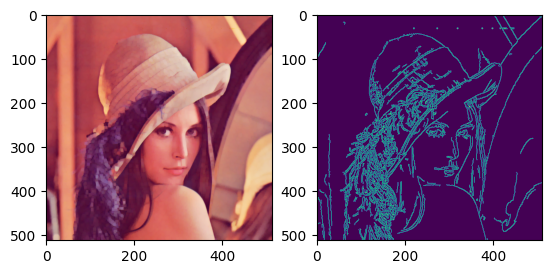

In [13]:
#load ini file
filename = 'imageproc.ini'
inireader = ImageProcIniReader(filename)
inireader.read()
inireader.deploy()

#lena画像パス
lena_path = inireader.lena_img_path

img = cv2.imread(lena_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# fig,aixs = plt.subplot(1,1)
kernel = np.ones((3,3))
img_ero = cv2.erode(img, kernel, iterations=2)
dst = cv2.dilate(img_ero, kernel, iterations=2)
edges = detect_edges(lena_path)

#グラフ表示領域
fig = plt.figure()

#グラフを追加する
ax_closing = fig.add_subplot(1, 2, 1)
ax_edges_canny = fig.add_subplot(1, 2, 2)


ax_closing.imshow(dst)
ax_edges_canny.imshow(edges)
plt.show()

125


c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in longlong_scalars
c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars
c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in longlong_scalars


<function matplotlib.pyplot.show(close=None, block=None)>

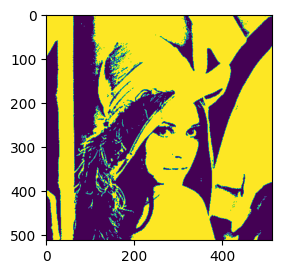

In [28]:
img = cv2.imread(lena_path, cv2.IMREAD_ANYDEPTH)
bin_threshold = otsu_threshold(img)
print(bin_threshold)
ret, img = cv2.threshold(img, bin_threshold, 255, cv2.THRESH_BINARY)
fig2 = plt.figure()
ax_otsu_lena = fig2.add_subplot(1, 2, 1)
ax_otsu_lena.imshow(img)
plt.show

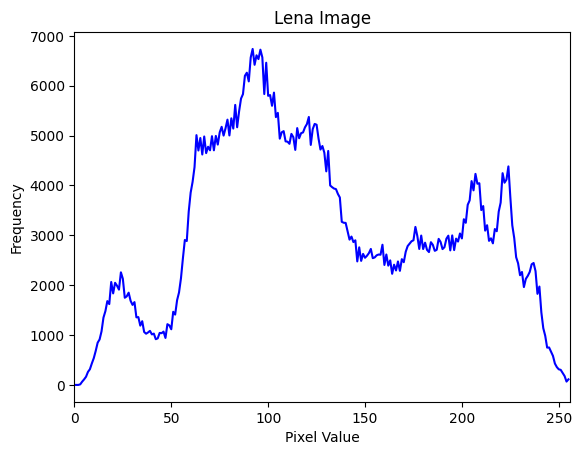

In [21]:
glay_lena = cv2.imread(lena_path, cv2.COLOR_RGB2GRAY)
plot_histogram(glay_lena, 'Lena Image')

In [64]:
#Math Function

#二乗平方平均
def RMS(numbers):
    """Calculate RMS(root mean square)"""
    squared_sum = sum(x ** 2 for x in numbers)
    mean_squared = squared_sum / len(numbers)
    rms = math.sqrt(mean_squared), 3
    return rms

# 離散フーリエ変換
def DFT(signal):
    N = len(signal)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    transformed_signal = np.dot(e, signal)
    return transformed_signal

#楕円率(長径に対する短径の比)
def calc_elipicity(long_a, short_b, ratio=3):
    return round(short_b/long_a, ratio)

#2枚の画像を比較してRMSを算出する
def compare_img_RMS(img_src, img_ref, height=512, width=512):
    diff = cv2.absdiff(img_src, img_ref)
    sum = cv2.add(img_src, img_ref)

    tmp_list = []
    for y in range(height):
        for x in range(width):
             tmp_list.append(diff[y, x] / sum[y,x])
    
    result = RMS(tmp_list)
    return result



## 離散フーリエ変換(DFT)

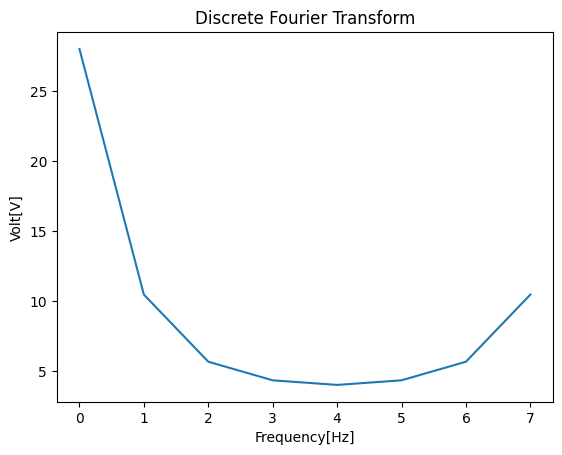

In [23]:
# 入力信号の作成
signal = np.array([0, 1, 2, 3, 4, 5, 6, 7])

# 離散フーリエ変換の実行
transformed_signal = DFT(signal)

# 結果のグラフ表示
plt.plot(np.abs(transformed_signal))
plt.title('Discrete Fourier Transform')
plt.xlabel('Frequency[Hz]')
plt.ylabel('Volt[V]')
plt.show()

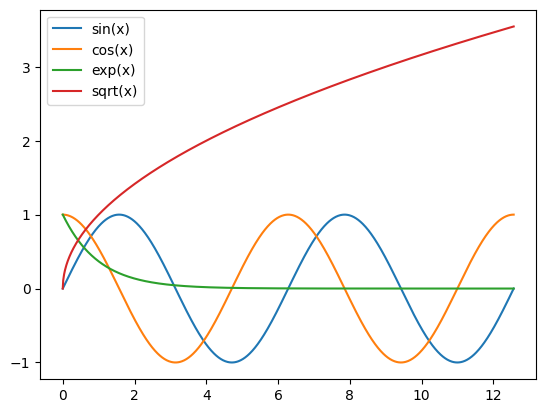

Elipicity0.5


In [66]:
# height= img.shape[0]
# width = img.shape[1]
# val = compare_img_RMS(img, dst, height, width)

fig2, ax = plt.subplots()
x = np.linspace(0, 4 * np.pi, 1000)
ax.plot(x, np.sin(x), label="sin(x)")
ax.plot(x, np.cos(x), label="cos(x)")
ax.plot(x, np.exp(-x), label="exp(x)")
ax.plot(x, np.sqrt(x), label="sqrt(x)")
ax.legend()
# fig2.savefig("plot.png") #画像で保存
plt.show()

e = calc_elipicity(10, 5)
print('Elipicity' + str(e))